# Librerias

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Obtener los datos

In [2]:
scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',
"https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("data-365420-bc47f140dd2b.json", scope)
client = gspread.authorize(creds)
sheet = client.open("Información de contacto (Respuestas)").sheet1
data_sheet = sheet.get_all_records() # una lista 

# Limpieza y manipulación de los datos

In [3]:
df_survey = pd.DataFrame(data_sheet)
columns = df_survey.columns
df_survey = df_survey.rename(columns={columns[i]: i for i in range(len(columns))})
df_survey.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10/6/2022 18:48:37,adamianmm@gmail.com,Damian,3,CDMX,22,Hombre,"Pop, Reggaeton, Clásica, Rock, Hip Hop",Gatos,"Naruto, Grey's Anatomy, Lost",3,11:30:00 AM,Si
1,10/6/2022 18:49:07,sebastianzarraga43@aragon.unam.mx,Sebastian Zaaraga,10,Mexico,22,Hombre,"Reggaeton, Hip Hop","Perros, Peces","Game of Thrones , Naruto , Sons of Anarchy",1,10:00:00 AM,Si
2,10/6/2022 18:49:16,mariogaiden2@ciencias.unam.mx,Mario Guadiana Martinez,10,Guanajuato,27,Hombre,Hip Hop,Gatos,"Alf, príncipe de beler, prision break",2,11:00:00 AM,No
3,10/6/2022 18:49:33,cecy.95.ad@gmail.com,Cecilia,14,Sinaloa,26,Mujer,Pop,,"one piece, siete pecados capitales.",3,11:30:00 AM,No
4,10/6/2022 18:49:33,fabricioescalantep@gmail.com,Fabricio E,13,CDMX,21,Hombre,"Metal, Reggaeton, Clásica, Rock, Jazz",Perros,"Mindhunter, How I Met Your Mother, Attack On T...",2,3:30:00 AM,Si


In [4]:
time =  pd.to_datetime(df_survey[0])
df_survey['time'] = time.dt.hour+time.dt.minute/60
df_survey['time']

0     18.800000
1     18.816667
2     18.816667
3     18.816667
4     18.816667
5     18.816667
6     18.833333
7     18.833333
8     18.833333
9     18.833333
10    18.850000
11    18.850000
12    18.866667
13    18.866667
14    18.916667
15    20.783333
Name: time, dtype: float64

In [5]:
mail = df_survey[1].apply(lambda x: x.split("@")[1])
df_survey["mail"] = mail.apply(lambda x: 1 if x == "gmail.com" else 0)
df_survey['mail'].head()

0    1
1    0
2    0
3    1
4    1
Name: mail, dtype: int64

In [6]:
df_survey["number"] = df_survey[3].replace("", 0).replace("Ocho", 8)
df_survey["number"].head()

0     3.0
1    10.0
2    10.0
3    14.0
4    13.0
Name: number, dtype: float64

In [7]:
df_states = pd.get_dummies(df_survey[4].replace("Estado de México", "Edo Mex").replace("Ciudad de México ", "CDMX"))

In [8]:
mean = np.mean(df_survey[5][:list(df_survey[5]).index('?')].astype(int))
df_survey["age"] = df_survey[5].replace("?", int(mean))
df_survey["age"].head()

0    22
1    22
2    27
3    26
4    21
Name: age, dtype: int64

In [9]:
df_survey["gender"] = df_survey[6].apply(lambda x: 1 if x == "Hombre" else 0)
df_survey["gender"].head()

0    1
1    1
2    1
3    0
4    1
Name: gender, dtype: int64

In [10]:
music_list = df_survey[7].str.split(",")
unique_music = set([item.strip().lower() for sublist in music_list.tolist() for item in sublist])

In [11]:
music_genres = {}
for gen in unique_music:
    music_genres[gen] = music_list.apply(lambda x: 1 if gen in [ele.strip().lower() for ele in x] else 0)

In [12]:
df_music = pd.DataFrame(music_genres)
df_music.columns = ["mus_" + x for x in df_music.columns]

In [13]:
df_survey = pd.concat([df_survey, df_music], axis=1)

In [14]:
pets_list = df_survey[8].str.split(",")
unique_pets = set([item.strip().lower() for sublist in pets_list.tolist() for item in sublist])
pets_dict = {}
for pet in unique_pets:
    pets_dict[pet] = pets_list.apply(lambda x: 1 if pet in [ele.strip().lower() for ele in x] else 0)

df_pet = pd.DataFrame(pets_dict)
df_pet.columns = ["pets_" + x for x in df_pet.columns]
df_survey = pd.concat([df_survey, df_pet], axis=1)

In [15]:
shows_list = df_survey[9].str.split(",")
unique_shows = [item.replace("&", "y").strip().lower() if "&" in item else item.strip().lower() for sublist in shows_list.tolist() for item in sublist]
popular = pd.Series(unique_shows).value_counts().head(7).index.tolist()

In [16]:
for i in range(len(popular)):
    if i == 0:
        pops = shows_list.apply(
            lambda x: 1 if popular[i] in [item.replace("&", "y").strip().lower() if "&" in item else item.strip().lower() for item in x] else 0)
    else:
        pops_ = shows_list.apply(
            lambda x: 1 if popular[i] in [item.replace("&", "y").strip().lower() if "&" in item else item.strip().lower() for item in x] else 0)

        pops += pops_

In [17]:
df_survey["popular_tv_shows"] = pops

In [18]:
df_survey['extro_scale'] = df_survey[10]
df_survey['extro_scale'].head()

0    3
1    1
2    2
3    3
4    2
Name: extro_scale, dtype: int64

In [19]:
def correct_time(x):
    if ":" in x[:2]:
        if int(x[:1]) > 6 and x[-2:] == "AM":
            return x.replace("AM", "PM")
    else:
        if int(x[:2]) < 12 and x[-2:] == "AM":
            return x.replace("AM", "PM")
        elif int(x[:2]) == 12 and x[-2:] == "PM":
            return x.replace("PM", "AM")
        
    return x

In [20]:
df_survey[11] = df_survey[11].apply(correct_time)
bedtime = pd.to_datetime(df_survey[11])
df_survey['bedtime'] = bedtime.dt.hour+bedtime.dt.minute/60


In [21]:
columns

Index(['Marca temporal', 'Dirección de correo electrónico', 'Nombre',
       'Escribe un número',
       'En qué estado vivo (departamento/provincia si no estoy en México)',
       'Edad', 'Género', 'Me gusta  la música:', 'Animales que me tengo',
       'Shows que me gustan 3 separados por coma (ej. Game of Thrones, Naruto, Betty la Fea)',
       'Me considero', 'Mi hora de dormir es a las',
       'Sé quién es Zaboo Mafoo'],
      dtype='object')

In [22]:
df_survey["zaboo_mafoo"] = df_survey[12].apply(lambda x: 1 if x == "Si" else 0)
df_survey["zaboo_mafoo"].head()

0    1
1    1
2    0
3    0
4    1
Name: zaboo_mafoo, dtype: int64

# PCA 

In [23]:
cont_cols = [x for x in df_survey.columns if type(x) != type(1)]

In [24]:
X = df_survey[cont_cols]

In [25]:
m_corr = X.corr()

In [26]:

# Perfilamiento
# estamos agrupando por la media

# Tiene la escala más baja de extro_gato
# significa que son jovenes, son introvertidos, y que no tienen gatos y les gusta el metal
# 0; El de la esquina en las fiestas 

# es grande, tiene gatosm y es extrovertido
# en perro_intenso esta en la mitad de la escala
# 1; viva el rock

# les encanta el perreo, tienen perros, y otras mascotas
# en extro_gato son el segundo grupo más alto 
# 2; huachiturros

# no les gusta el reggaeton, no tienen mascotas de ningun tipo - 
# son el segundo grupo más bajo por lo cual, puede que tengan o gatos o les guste el metal 
# 3; Neo hipster
#pd.pivot_table(union, index="Cluster")

In [27]:
# ['age', 'pets_gatos', 'extro_scale', 'mus_clásica', 'mus_pop', 'bedtime']

# ['mus_reggaeton', 'zaboo_mafoo', 'pets_perros', 'pets_otros', 'popular_tv_shows', 'mus_rock']

m_corr > 0.3

,time,mail,number,age,gender,mus_clásica,mus_rock,mus_metal,mus_jazz,mus_reggaeton,mus_pop,mus_hip hop,pets_,pets_peces,pets_perros,pets_gatos,pets_otros,popular_tv_shows,extro_scale,bedtime,zaboo_mafoo
time,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
mail,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
number,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
age,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
gender,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
mus_clásica,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,True
mus_rock,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,True,False,True,False,False,False
mus_metal,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,True,False,False,False,False
mus_jazz,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
mus_reggaeton,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,False,False


In [28]:
X_1 = X.loc[:,['age', 'pets_gatos', 'extro_scale', 'mus_clásica', 'mus_pop', 'bedtime']]
X_2 = X.loc[:,['mus_reggaeton', 'zaboo_mafoo', 'pets_perros', 'pets_otros', 'popular_tv_shows', 'mus_rock']]

In [29]:
pca_1 = PCA(n_components=1)
pca_1.fit(X_1)
X_1["X"] = (pca_1.fit_transform(X_1).reshape(1,16)[0])

In [30]:
# el valor mas alto; tiene una edad grande, tiene gatos, es muy extrovertido, le gusta la musica clásica y le gusta el pop, se duermen despues de las 12
# el valor más bajo; tiene una edad joven, no tiene gatos, es poco introvertido, no le gusta la musica clásica, le gusta el pop, se duermen antes de las 12

#X_1.sort_values(by="X", ascending=False)
X_1.rename(columns={"X": "es_parte_de_crecer_timmy"}, inplace=True)

In [31]:
pca_2 = PCA(n_components=1)
pca_2.fit(X_2)
X_2["X"] = (pca_2.fit_transform(X_2).reshape(1,16)[0])

In [32]:
# el valor más alto; le gusta el reggaeton, no conoce a zaboo, tiene perros, no tiene otras mascotas, a visto 3 shows populares, le gusta el rock
# el valor más bajo; no le gusta el reggaeton, no conoce a zaboo, no tiene perros ni otras mascotas, no a vistos shows populares, no le gusta el rock
#X_2.sort_values(by="X", ascending=False)
X_2.rename(columns={"X": "personas_fiesteras"}, inplace=True)

In [33]:
union = pd.concat([X_1, X_2], axis=1)[["es_parte_de_crecer_timmy", "personas_fiesteras"]]

<AxesSubplot: xlabel='personas_fiesteras', ylabel='es_parte_de_crecer_timmy'>

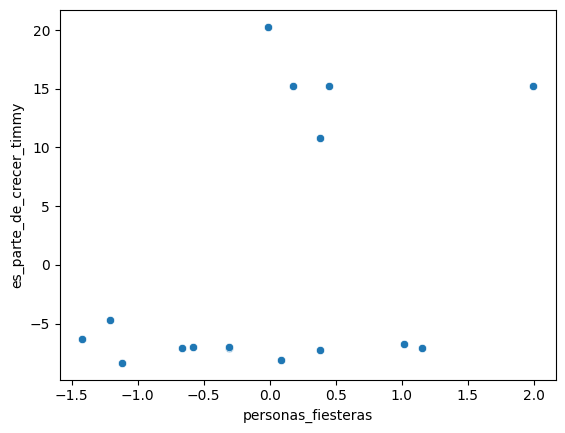

In [34]:
sns.scatterplot(data=union, x='personas_fiesteras', y='es_parte_de_crecer_timmy')

# Estandarización de los valores

In [35]:
scaler = StandardScaler()

In [36]:
union_s = scaler.fit_transform(union)

# Modelo

### ElBow Method

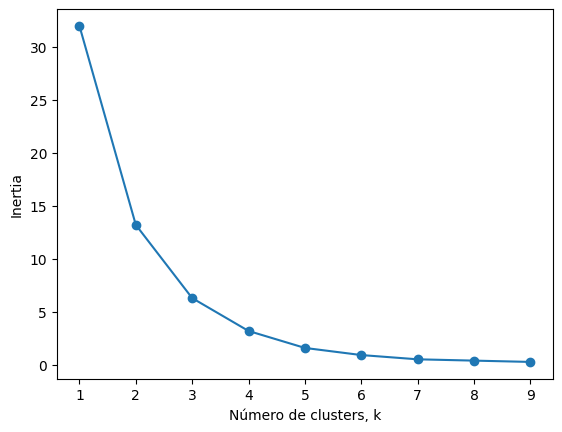

In [37]:
inertias = {k: KMeans(n_clusters=k).fit(union_s).inertia_ for k in range(1, 10)}

plt.plot(list(inertias.keys()), 
        list(inertias.values()), '-o')
plt.xlabel('Número de clusters, k')
plt.ylabel('Inertia')
plt.xticks(list(inertias.keys()))
plt.show()

como podemos observar en la gráfica podríamos intuir que el mejor número de cluster es 6, ya que la inercia disminuida en los siguientes cluster es muy pequeña en comparación de los anteriores clusters.

para comprobar si es correcto lo anterior dicho y como contamos con pocos datos podemos hacer uso del silhouette method. 

### Silhouette Method

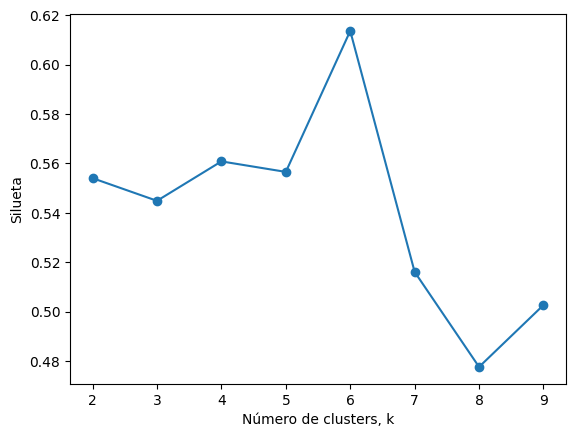

In [38]:
silhouettes = {k: silhouette_score(union_s, KMeans(n_clusters=k).fit_predict(union_s)) for k in range(2, 10)}

plt.plot(list(silhouettes.keys()), 
        list(silhouettes.values()), '-o')
plt.xlabel('Número de clusters, k')
plt.ylabel('Silueta')
plt.xticks(list(silhouettes.keys()))
plt.show()

como podemos observar la media del silhueta score que más se acerca a 1 pertenece al cluster 6, por lo cual lo anteriormente propuesto es correcto y **Ese sera el número utilizado en nuestro modelo**

### Modelo con la mejor k

In [39]:
model = KMeans(n_clusters=6)
model.fit(union_s)

KMeans(n_clusters=6)

<AxesSubplot: xlabel='personas_fiesteras', ylabel='es_parte_de_crecer_timmy'>

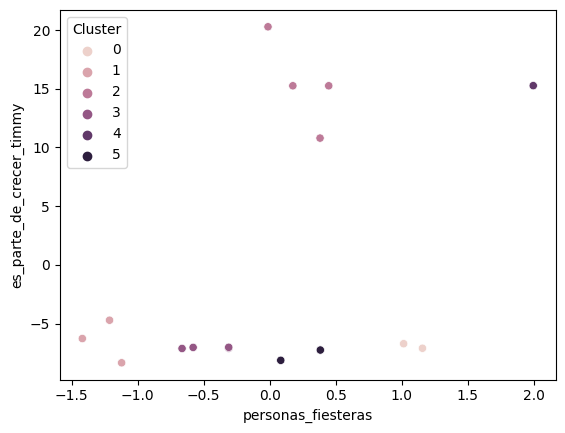

In [40]:
union["Cluster"] = model.labels_
sns.scatterplot(data=union, x='personas_fiesteras', y='es_parte_de_crecer_timmy', hue="Cluster")

# Perfilamiento

In [41]:
# es parte de crecer timmy
# el valor mas alto; tiene una edad grande, tiene gatos, es muy extrovertido, le gusta la musica clásica y le gusta el pop, se duermen despues de las 12
# el valor más bajo; tiene una edad joven, no tiene gatos, es poco introvertido, no le gusta la musica clásica, le gusta el pop, se duermen antes de las 12

# personas_fiesteras
# el valor más alto; le gusta el reggaeton, no conoce a zaboo, tiene perros, no tiene otras mascotas, a visto 3 shows populares, le gusta el rock
# el valor más bajo; no le gusta el reggaeton, no conoce a zaboo, no tiene perros ni otras mascotas, no a vistos shows populares, no le gusta el rock


In [42]:
# el tercer grupo más bajo de es parte de crecer timmy y el segundo más alto en personas fiesteras
# 0 La generación z

# el tercero más alto de es parte de crecer timmy y el más bajo de personas fiesteras
# 1 los milennials

# el más alto de es parte de crecer timmy y el tercero más alto de personas fiesteras
# 2 los chavo-rucos

# el segundo más bajo de es parte de crecer timmy y el segundo más bajo de personas fiesteras
# 3 Los que bailan en su cuarto

# son el segundo más alto de es parte de crecer timmy y el más alto de personas fiesteras
# 4 los ninis

# son los más bajos de es parte de crecer timmy y el tercero más bajo de personas fiesteras
# 5 Los de la esquina en las fiestas
pd.pivot_table(union, index="Cluster").sort_values(by="es_parte_de_crecer_timmy")

,es_parte_de_crecer_timmy,personas_fiesteras
Cluster,,
5,-7.697749,0.233354
3,-7.070970,-0.466896
0,-6.913930,1.085859
1,-6.448064,-1.252360
4,15.265741,1.996785
2,15.396423,0.247363


In [43]:
id = df_survey.loc[:,[0,2]]
clusters = model.labels_
id["Cluster"] = clusters
id

,0,2,Cluster
0,10/6/2022 18:48:37,Damian,5
1,10/6/2022 18:49:07,Sebastian Zaaraga,0
2,10/6/2022 18:49:16,Mario Guadiana Martinez,1
3,10/6/2022 18:49:33,Cecilia,3
4,10/6/2022 18:49:33,Fabricio E,2
5,10/6/2022 18:49:54,Matias,0
6,10/6/2022 18:50:03,Viviana,2
7,10/6/2022 18:50:10,Fernanda Sandoval,2
8,10/6/2022 18:50:20,Jorge Ramiro,4
9,10/6/2022 18:50:38,Gerardo,3
